# GloFAS probabilistic

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import os

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.utils import blob
from src.datasources import glofas
from src.constants import *

In [3]:
# glofas.process_reforecast_frac()

In [4]:
ref = glofas.load_reforecast_frac()

In [5]:
ref["time"].dt.year.nunique()

20

## Calculate reanalysis peaks

In [19]:
rp_a = 3

rea = glofas.load_reanalysis()
rea = rea[rea["time"].dt.year.isin(ref["time"].dt.year.unique())]
rea_peaks = rea.loc[rea.groupby(rea["time"].dt.year)["dis24"].idxmax()]
q = rea_peaks["dis24"].quantile(1 - 1 / rp_a)
rea_peaks["trigger"] = rea_peaks["dis24"] > q
rea_peaks["year"] = rea_peaks["time"].dt.year
rea_peaks["cerf"] = rea_peaks["year"].isin(CERF_YEARS)
rea_peaks["rank"] = rea_peaks["dis24"].rank(ascending=False)
rea_peaks["rp"] = len(rea_peaks) / rea_peaks["rank"]
rea_peaks = rea_peaks.sort_values("rank", ascending=False)

In [20]:
rea_peaks

,time,dis24,trigger,year,cerf,rank,rp
13411,2015-09-20,1563.8047,False,2015,False,20.0,1.000000
12658,2013-08-28,1611.9375,False,2013,True,19.0,1.052632
14113,2017-08-22,1717.8984,False,2017,False,18.0,1.111111
10127,2006-09-23,1733.7578,False,2006,False,17.0,1.176471
9381,2004-09-07,1856.5781,False,2004,False,16.0,1.250000
15248,2020-09-30,1946.8281,False,2020,False,15.0,1.333333
9723,2005-08-15,2077.3281,False,2005,False,14.0,1.428571
11205,2009-09-05,2169.9062,False,2009,False,13.0,1.538462
10491,2007-09-22,2235.7812,False,2007,False,12.0,1.666667
15530,2021-07-09,2253.2969,False,2021,False,11.0,1.818182


In [8]:
ref

,time,leadtime,valid_time,2yr_thresh,3yr_thresh,5yr_thresh
0,2003-07-03,1,2003-07-04,0.0,0.0,0.0
1,2003-07-03,2,2003-07-05,0.0,0.0,0.0
2,2003-07-03,3,2003-07-06,0.0,0.0,0.0
3,2003-07-03,4,2003-07-07,0.0,0.0,0.0
4,2003-07-03,5,2003-07-08,0.0,0.0,0.0
...,...,...,...,...,...,...
26455,2022-10-30,31,2022-11-30,0.0,0.0,0.0
26456,2022-10-30,32,2022-12-01,0.0,0.0,0.0
26457,2022-10-30,33,2022-12-02,0.0,0.0,0.0
26458,2022-10-30,34,2022-12-03,0.0,0.0,0.0


## Calculate reforecast peaks

Filtering by maximum leadtime

In [9]:
rp_f = 3
lt_min = 7

val_col = "2yr_thresh"

dfs = []

for lt in ref["leadtime"].unique():
    if lt < lt_min or lt > 30:
        continue

    dff = ref[(ref["leadtime"] <= lt) & (ref["leadtime"] >= lt_min)]
    df_in = dff.loc[dff.groupby(dff["time"].dt.year)[val_col].idxmax()]
    df_in["lt_max"] = lt
    thresh = df_in[val_col].quantile(1 - 1 / rp_f)
    df_in["trigger"] = df_in[val_col] >= thresh
    print(lt, thresh)
    dfs.append(df_in)

ref_peaks = pd.concat(dfs, ignore_index=True)
ref_peaks["year"] = ref_peaks["time"].dt.year

7 0.6666666666666667
8 0.7666666666666668
9 0.7666666666666668
10 0.7666666666666668
11 0.7666666666666668
12 0.8
13 0.8
14 0.8
15 0.9
16 0.9666666666666668
17 0.9666666666666668
18 0.9666666666666668
19 0.9666666666666668
20 0.9666666666666668
21 0.9666666666666668
22 0.9666666666666668
23 0.9666666666666668
24 0.9666666666666668
25 0.9666666666666668
26 0.9666666666666668
27 0.9666666666666668
28 1.0
29 1.0
30 1.0


## Compare reanalysis to reforecast

### Calcuate TP/FP/TN/FN

In [10]:
compare = rea_peaks.merge(ref_peaks, on="year", suffixes=["_a", "_f"])
for indicator in ["cerf", "trigger_a"]:
    compare[f"TP_{indicator}"] = compare[indicator] & compare["trigger_f"]
    compare[f"FP_{indicator}"] = ~compare[indicator] & compare["trigger_f"]
    compare[f"TN_{indicator}"] = ~compare[indicator] & ~compare["trigger_f"]
    compare[f"FN_{indicator}"] = compare[indicator] & ~compare["trigger_f"]

compare = compare.sort_values(["year", "lt_max"])

### Calculate TPR etc metrics

In [11]:
dicts = []
for lt, group in compare.groupby("lt_max"):
    TPR = group["TP_trigger_a"].sum() / group["trigger_a"].sum()
    PPV = group["TP_trigger_a"].sum() / group["trigger_f"].sum()
    TPR_C = group["TP_cerf"].sum() / group["cerf"].sum()
    PPV_C = group["TP_cerf"].sum() / group["trigger_f"].sum()
    dicts.append(
        {"TPR": TPR, "PPV": PPV, "TPR_C": TPR_C, "PPV_C": PPV_C, "lt_max": lt}
    )

metrics = pd.DataFrame(dicts)
metrics

,TPR,PPV,TPR_C,PPV_C,lt_max
0,0.857143,0.857143,0.666667,0.285714,7
1,0.714286,0.714286,0.666667,0.285714,8
2,0.714286,0.714286,0.666667,0.285714,9
3,0.714286,0.714286,0.666667,0.285714,10
4,0.714286,0.714286,0.666667,0.285714,11
5,0.857143,0.750000,0.666667,0.250000,12
6,0.857143,0.750000,0.666667,0.250000,13
7,0.857143,0.750000,0.666667,0.250000,14
8,0.857143,0.750000,0.666667,0.250000,15
9,0.857143,0.857143,0.666667,0.285714,16


In [12]:
compare[compare["trigger_f"]].set_index("lt_max").loc[14]

,time_a,dis24,trigger_a,year,cerf,rank,rp,time_f,leadtime,valid_time,...,5yr_thresh,trigger_f,TP_cerf,FP_cerf,TN_cerf,FN_cerf,TP_trigger_a,FP_trigger_a,TN_trigger_a,FN_trigger_a
lt_max,,,,,,,,,,,,,,,,,,,,,
14,2003-09-19,3312.0156,True,2003,False,2.0,10.000000,2003-08-28,8,2003-09-05,...,0.1,True,False,True,False,False,True,False,False,False
14,2010-09-07,3109.2578,True,2010,False,4.0,5.000000,2010-09-07,7,2010-09-14,...,0.0,True,False,True,False,False,True,False,False,False
14,2012-08-21,3110.0781,True,2012,False,3.0,6.666667,2012-09-04,13,2012-09-17,...,0.0,True,False,True,False,False,True,False,False,False
14,2014-08-23,2918.1250,True,2014,False,5.0,4.000000,2014-08-28,12,2014-09-09,...,0.0,True,False,True,False,False,True,False,False,False
14,2016-09-22,2364.7734,False,2016,False,10.0,2.000000,2016-09-18,8,2016-09-26,...,0.0,True,False,True,False,False,False,True,False,False
14,2018-09-28,2547.9062,True,2018,True,7.0,2.857143,2018-09-04,10,2018-09-14,...,0.0,True,True,False,False,False,True,False,False,False
14,2019-10-11,2440.0547,False,2019,False,9.0,2.222222,2019-08-31,10,2019-09-10,...,0.0,True,False,True,False,False,False,True,False,False
14,2022-08-19,5347.1720,True,2022,True,1.0,20.000000,2022-08-31,7,2022-09-07,...,0.0,True,True,False,False,False,True,False,False,False


### Plot

For chosen max leadtime and return period

/var/folders/66/764yc5p92nvdc_nm3xmy5rn40000gn/T/ipykernel_44656/1116931373.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_lt["percent"] = compare_lt[val_col] * 100


Text(0.5, 1.0, 'Benue river at Wuroboki\nGloFAS yearly peaks (2003-2022)')

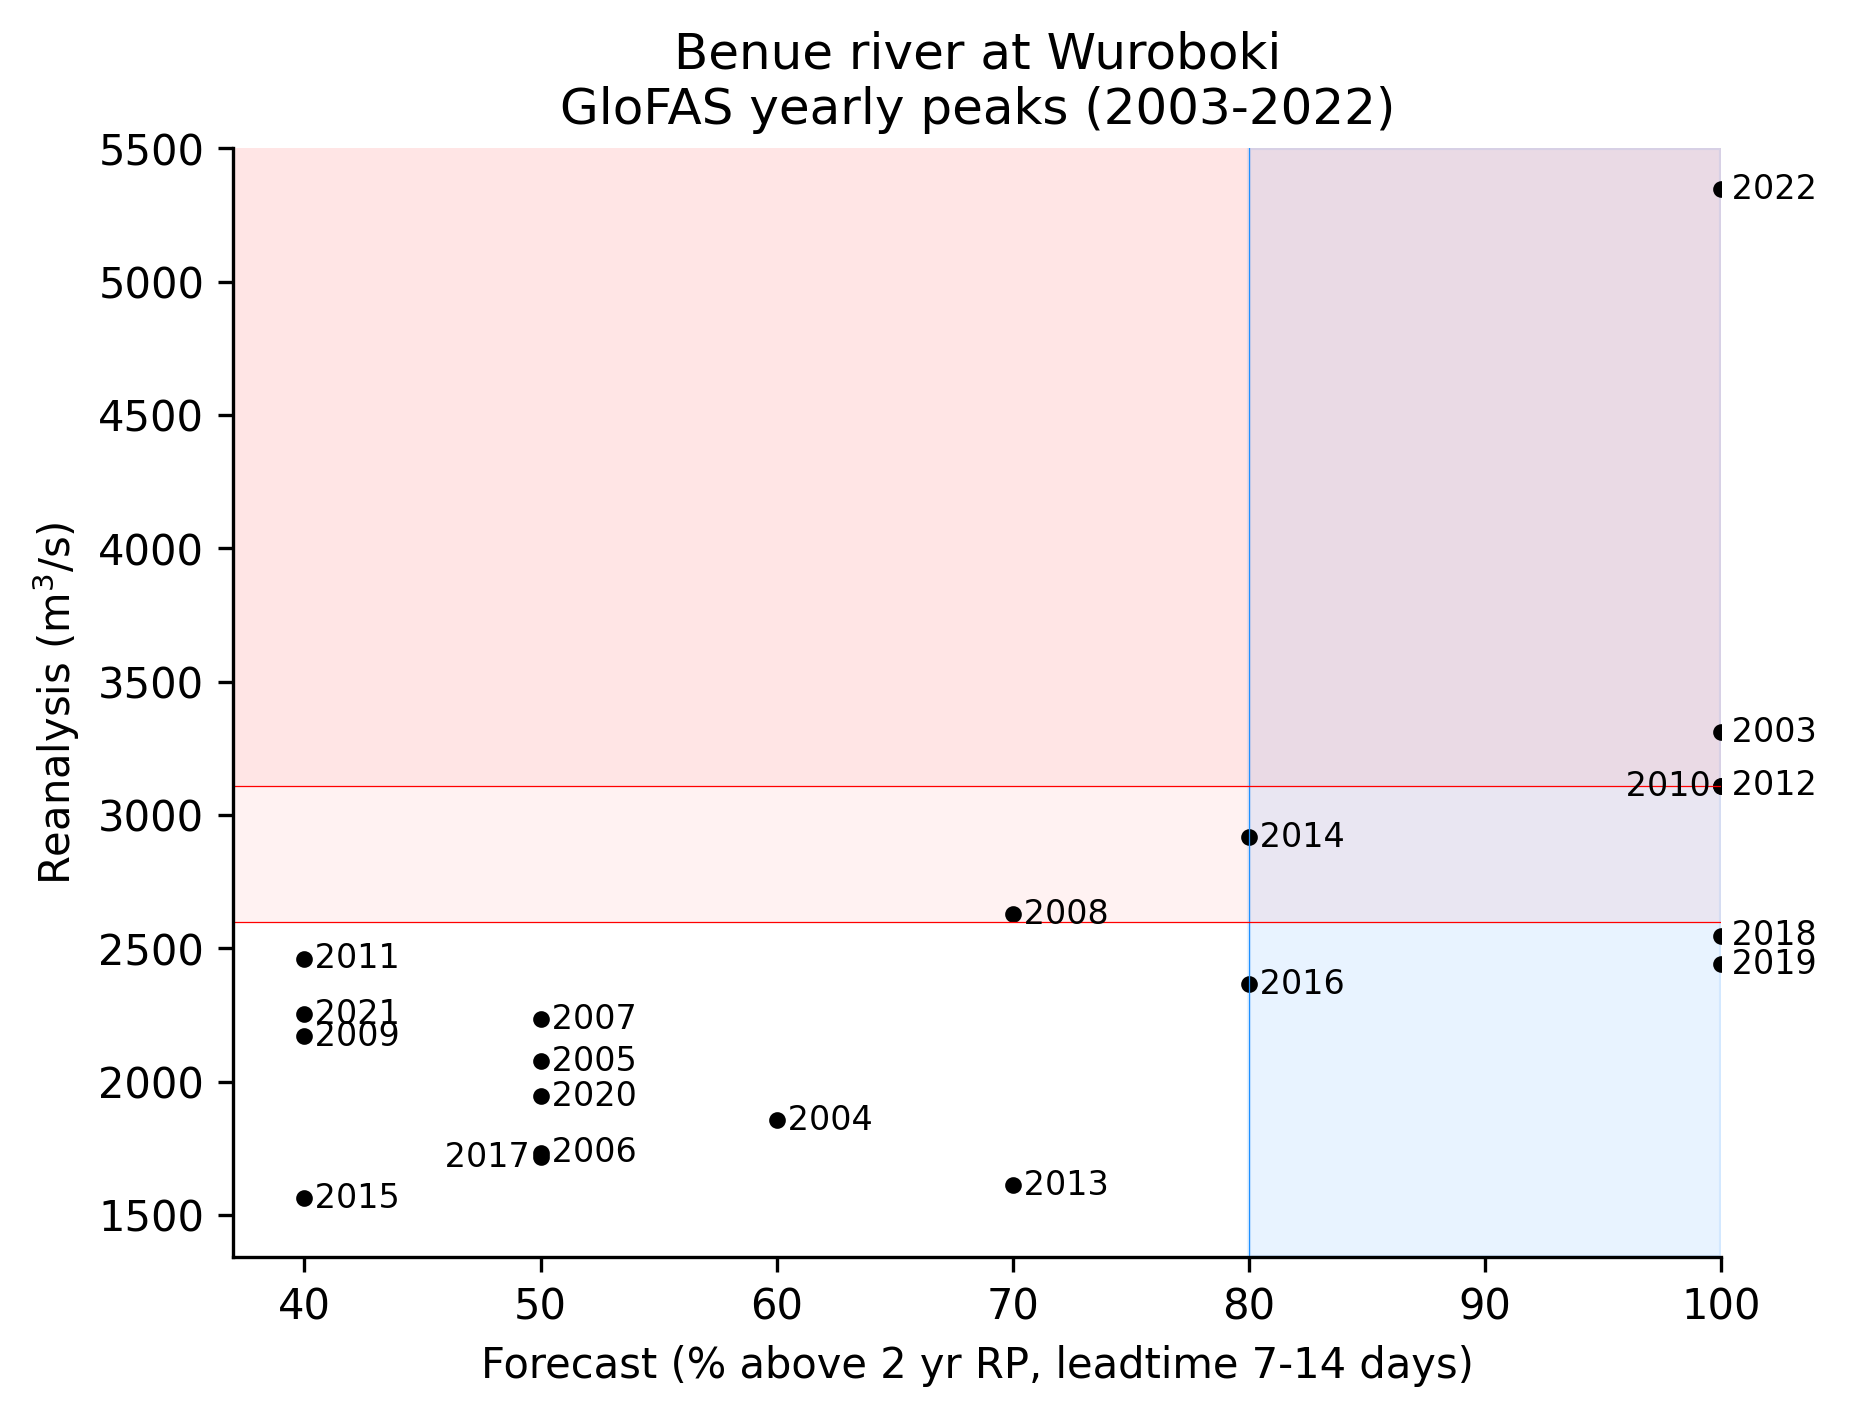

In [13]:
# 3yr
rp_a_3 = 2600
# 2yr
# rp_a_3 = 2364.7734
rp_a_5 = 3109
rp_f = 0.8 * 100
compare_lt = compare[compare["lt_max"] == 14]
compare_lt["percent"] = compare_lt[val_col] * 100
fig, ax = plt.subplots(dpi=300)
compare_lt.plot(
    y="dis24",
    x="percent",
    ax=ax,
    marker=".",
    color="k",
    linestyle="",
    legend=False,
)

ax.axvline(x=rp_f, color="dodgerblue", linestyle="-", linewidth=0.3)
ax.axvspan(
    rp_f,
    100,
    ymin=0,
    ymax=1,
    color="dodgerblue",
    alpha=0.1,
)

ax.axhline(y=rp_a_3, color="red", linestyle="-", linewidth=0.3)
ax.axhspan(
    rp_a_3,
    6000,
    color="red",
    alpha=0.05,
    linestyle="None",
)

ax.axhline(y=rp_a_5, color="red", linestyle="-", linewidth=0.3)
ax.axhspan(
    rp_a_5,
    6000,
    color="red",
    alpha=0.05,
    linestyle="None",
)

for year, row in compare_lt.set_index("year").iterrows():
    flip_years = [2017, 2010]
    ha = "right" if year in flip_years else "left"
    ax.annotate(
        f" {year} ",
        (row["percent"], row["dis24"]),
        color="k",
        fontsize=8,
        va="center",
        ha=ha,
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Reanalysis (m$^3$/s)")
ax.set_xlabel(f"Forecast (% above 2 yr RP, leadtime {lt_min}-14 days)")
ax.set_ylim(top=5500)
ax.set_xlim(right=100)
ax.set_title("Benue river at Wuroboki\nGloFAS yearly peaks (2003-2022)")

In [15]:
cols = ["year", "time_f", "leadtime"]
compare_lt[compare_lt["trigger_f"]][cols].rename(
    columns={
        "year": "Year",
        "time_f": "Trigger date",
        "leadtime": "Leadtime (days)",
    }
)

,Year,Trigger date,Leadtime (days)
439,2003,2003-08-28,8
391,2010,2010-09-07,7
415,2012,2012-09-04,13
367,2014,2014-08-28,12
247,2016,2016-09-18,8
319,2018,2018-09-04,10
271,2019,2019-08-31,10
463,2022,2022-08-31,7


In [16]:
dicts = []
for lt_max, group in compare.groupby("lt_max"):
    corr_in = group.corr()
    dicts.append(
        {
            "lt_max": lt_max,
            "2yr_thresh": corr_in.loc["dis24", "2yr_thresh"],
            "5yr_thresh": corr_in.loc["dis24", "5yr_thresh"],
        }
    )

df_corr = pd.DataFrame(dicts)
df_corr

,lt_max,2yr_thresh,5yr_thresh
0,7,0.737447,0.233224
1,8,0.720288,0.233224
2,9,0.708906,0.233224
3,10,0.668704,0.233224
4,11,0.667012,0.201172
5,12,0.669325,0.201172
6,13,0.641116,0.201172
7,14,0.653409,0.201172
8,15,0.622481,0.201172
9,16,0.625593,0.201172


<Axes: xlabel='lt_max'>

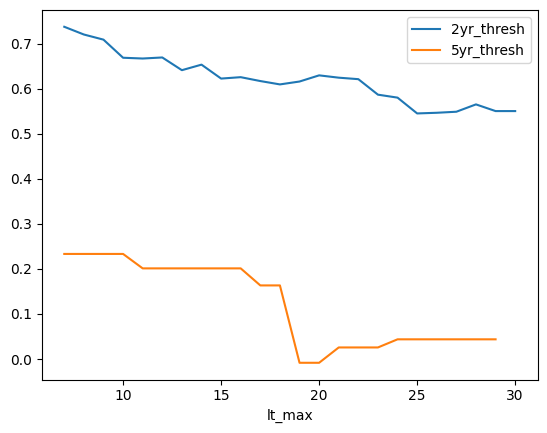

In [17]:
df_corr.set_index("lt_max").plot()